In [1]:
# 9-Compartment___Network
# Philip Cherian; 4th September, 2020

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy.random import randint,uniform,choice

Model details found [here](https://covid-measures.github.io/). Schematic for the model:

<img src="../images/model_schematic.png" alt="Drawing" style="width: 600px;"/>

Let's start off with the following parameters:
\begin{equation}
    \begin{aligned}
        \dot{S} &= - \beta \frac{S}{N} \left(C_P I_P + C_A I_A + C_S I_S + C_M I_M \right)\\
        \dot{E} &=  \beta \frac{S}{N} \left(C_P I_P + C_A I_A + C_S I_S + C_M I_M  \right) - \gamma E \\
        \dot{I_P} &= (1 - \alpha) \gamma E - \lambda_P I_P \\
        \dot{I_A} &= \alpha \gamma E - \lambda_A I_A\\
        \dot{I_S} &= (1-\mu) \lambda_P I_P - \lambda_S I_S\\
        \dot{I_M} &= \mu \lambda_P I_P - \lambda_M I_M\\
        \dot{H} &= \lambda_S I_S - \rho H \\
        \dot{R} &= \lambda_M I_M + \lambda_A I_A + (1 - \delta) \rho H\\
        \dot{D} &= \delta \rho H
    \end{aligned}
\end{equation}


In [2]:
# Parameters for the problem ###############################################

n_pop = 10000       # Total population
n_loc = 2500           # Total locations
n_net = 200           # Total networks (out of n_loc)
n_overlap = 100       # Overlap between networks and homes
n_hospitals=10       # Number of hospitals?

pars = [0.5, 0.192, 0.33, 0.5,   0.1428, 0.1736, 0.1428, 0.956, 0.068, 0.2 ]
     #[beta,gamma,alpha,lambdaP,lambdaA,lambdaS,lambdaM,  mu,  rho,  delta]

Cpars= [1, 0.66, 1, 1]
     #[Cp, Ca, Cs, Cm]

    
labels =[ "S", "E","IP","IA","IS","IM","H","R","D"] 
         #[0,  1,  2,  3,   4,   5,   6,   7,  8]

    
person_attr = 4  # 4 attributes for a person: state, home, network, current location

random_test_rate =0.1
test_sensitivity =0.99
finish_test_rate =1.0


In [3]:
def create_person(state, home):                  # Function to create a person with certain attributes
    net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
    return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


pop = np.zeros((n_pop,person_attr),int)          # Empty population
link_weight = np.zeros(n_pop,float)              # Array for link weights
is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
is_dead     = np.zeros(n_pop,bool)               # Boolean array, is dead? (Initial values, all "no".)
being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?

n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
                                                 # for all locations: both homes and networks

# Initial populations ###########

n_exp = 100

n0 = [n_pop-n_exp,  n_exp ,  0 ,  0 ,   0 ,  0 , 0 ,  0,  0 ]
        #[ S0,       E0,    IP0, IA0, IS0, IM0, IH0, R0, D0]


# n = np.array([n_pop-n_inf-n_hos-n_det, n_inf, n_det, n_hos, 0, 0,  0, 0  ],int)
#              # [ S         , I,   D, H, E, R, QU, QR ]

# old_n = np.copy(n)

##################################


for i in range(0,n_pop):
    home = randint(n_overlap-1,n_loc)              # Assign random homes for everyone with random network
    pop[i] = create_person(0,home)

    n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

    link_weight[i] = 0.1

r = choice(n_pop,size=n_exp,replace=False)         # Generate n_inf random numbers (r) from the total population without replacement

np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to exposed (1)

i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
np.add.at(n_per_location[:,1],i_locs,+1)           # Increment number of susceptible at these locations (idem)

if(np.sum(n_per_location) != n_pop):
    print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")

old_n_per_location = np.copy(n_per_location)

In [4]:
def Gillespie_Run(pars, Cpars, n_initial, population, T):
    
    output = np.append(0,n0)  # Output of the form t,[n_state_array]
    pop = np.copy(population)
    n = np.copy(n0)
    n_per_location = np.copy(old_n_per_location)
    
  
    # Parameters of the problem ############
    
    beta    = pars[0]
    gamma   = pars[1]
    alpha   = pars[2]
    lambdaP = pars[3]
    lambdaA = pars[4]
    lambdaS = pars[5]
    lambdaM = pars[6]
    mu      = pars[7]
    rho     = pars[8]
    delta   = pars[9]
    
    # Contact Parameters ###################
    
    Cp = Cpars[0]
    Ca = Cpars[1]
    Cs = Cpars[2]
    Cm = Cpars[3]
    
    #########################################
    
    t = 0.0       # float; start time

    V = 1          # float; spatial parameter (NOT "N"!)
    
    t_out = 0
    

    # Loop to compute results at every time-step

    while t < T:
        
        if(t>=t_out):
            output = np.vstack((output,np.append(int(t),n)))
            t_out += 1
            
        
        is_not_conf_or_dead = np.logical_not(is_confined+is_dead)   # Boolean array of people neither confined nor dead 
        
        a = np.zeros(14,float)
        
        # S -> E (sum over i of S_i(Cp*n_IP_i + Ca*n_IA_i + Cs*n_IS_i + Cm*n_IM_i) )
        a[0] = beta*np.sum(n_per_location[:,0] *(Cp* n_per_location[:,2] + Ca*n_per_location[:,3] + Cs*n_per_location[:,4] + Cm*n_per_location[:,5]) )
        
#         for i in range(0,n_pop):
#             if pop[i][0] == 0:
#                 a[0] += beta* (Cp*n_per_location[pop[i][3] ][2] + Ca*n_per_location[pop[i][3] ][3] + Cs*n_per_location[pop[i][3] ][4] + Cm*n_per_location[pop[i][3] ][5]   )
        
        
        a[1] = a[0] + (1 - alpha) * gamma * n[1]
        a[2] = a[1] + alpha * gamma * n[1]
        a[3] = a[2] + (1 - mu) * lambdaP * n[2]
        a[4] = a[3] + mu * lambdaP * n[2]
        a[5] = a[4] + lambdaA * n[3]
        a[6] = a[5] + lambdaS * n[4]
        a[7] = a[6] + lambdaM * n[5]
        a[8] = a[7] + (1 - delta) * rho * n[6]
        a[9] = a[8] + delta * rho * n[6]
        a[10]= a[9] + np.sum(is_not_conf_or_dead)*random_test_rate
        a[11]= a[10]+ np.sum(being_tested)*finish_test_rate 
        a[12]= a[11]+ np.sum(is_not_conf_or_dead*link_weight)
        
        
        dt = -np.log(uniform(0.0, 1.0)) / a[12]          # Pick the next time step
        t = t + dt                                    # increment time

        p = uniform(0.0,1.0) * a[12]                     # Choose which process occurs
        
        
        if p < a[0]:  # S -> E
            
            psum = 0
            
            for i in range(0,n_pop):
                if pop[i][0] == 0:
                    psum += beta* (Cp*n_per_location[pop[i][3] ][2] + Ca*n_per_location[pop[i][3] ][3] + Cs*n_per_location[pop[i][3] ][4] + Cm*n_per_location[pop[i][3] ][5]   )
                    
                    if(psum > p):
                        break
                
            # Set them to be exposed
            pop[i][0] = 1
            
            n[0] = n[0] - 1 
            n[1] = n[1] + 1
            
            n_per_location[pop[i][3]][0] -= 1
            n_per_location[pop[i][3]][1] += 1
            
#             n_S = n_S - 1
#             n_E = n_E + 1

            
        elif p < a[1]:  # E -> IP
            psum = a[0]
            
            for i in range(0,n_pop):
                if pop[i][0] == 1:
                    psum += (1 - alpha) * gamma
                    
                    if(psum > p):
                        break
                
            # Set them to presymptomatic infected
            pop[i][0] = 2
            
            n[1] = n[1] - 1 
            n[2] = n[2] + 1
            
            n_per_location[pop[i][3]][1] -= 1
            n_per_location[pop[i][3]][2] += 1
            
#             n_E  = n_E - 1
#             n_IP = n_IP + 1
        
        elif p < a[2]:  # E -> IA 
            psum = a[1]
            
            for i in range(0,n_pop):
                if pop[i][0] == 1:
                    psum += alpha * gamma
                    
                    if(psum > p):
                        break
                
            # Set them to asymptomatic infected
            pop[i][0] = 3
            
            n[1] = n[1] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][1] -= 1
            n_per_location[pop[i][3]][3] += 1
            
            
#             n_E   = n_E - 1
#             n_IA  = n_IA + 1
        
        elif p < a[3]: # IP -> IS
            psum = a[2]
            
            for i in range(0,n_pop):
                if pop[i][0] == 2:
                    psum += (1 - mu) * lambdaP
                    
                    if(psum > p):
                        break
                
            # Set them to severe infected
            pop[i][0] = 4
            
            n[2] = n[2] - 1 
            n[4] = n[4] + 1
            
            n_per_location[pop[i][3]][2] -= 1
            n_per_location[pop[i][3]][4] += 1
            
#             n_IP = n_IP - 1 
#             n_IS = n_IS + 1
            
        elif p < a[4]: # IP -> IM
            
            psum = a[3]
            
            for i in range(0,n_pop):
                if pop[i][0] == 2:
                    psum += mu * lambdaP
                    
                    if(psum > p):
                        break
                
            # Set them to mild infected
            pop[i][0] = 5
            
            n[2] = n[2] - 1 
            n[5] = n[5] + 1
            
            n_per_location[pop[i][3]][2] -= 1
            n_per_location[pop[i][3]][5] += 1
            
            
#             n_IP = n_IP - 1
#             n_IM = n_IM + 1
            
        elif p < a[5]: # IA -> R
            psum = a[4]
            
            for i in range(0,n_pop):
                if pop[i][0] == 3:
                    psum += lambdaA
                    
                    if(psum > p):
                        break
                
            # Set them to recovered
            pop[i][0] = 7
            
            n[3] = n[3] - 1 
            n[7] = n[7] + 1
            
            n_per_location[pop[i][3]][3] -= 1
            n_per_location[pop[i][3]][7] += 1
            
#             n_IA = n_IA - 1
#             n_R  = n_R + 1
            
        elif p < a[6]:   # IS -> H
            psum = a[5]
            
            for i in range(0,n_pop):
                if pop[i][0] == 4:
                    psum += lambdaS
                    
                    if(psum > p):
                        break
                
            # Set them to be hospitalised, move them to a "hospital" and confine them
            pop[i][0] = 6
            
            is_confined[i] = True
            
            n[4] = n[4] - 1 
            n[6] = n[6] + 1
            
            n_per_location[pop[i][3]][4] -= 1
            
            pop[i][3] = randint(n_hospitals)      # Move them to a hospital location
            
            n_per_location[pop[i][3]][6] += 1     # Incrememnt number of hospitalised there
            
#             n_IS = n_IS - 1
#             n_H  = n_H + 1
            
        elif p < a[7]:  # IM -> R
            psum = a[6]
            
            for i in range(0,n_pop):
                if pop[i][0] == 5:
                    psum += lambdaM
                    
                    if(psum > p):
                        break
                
            # Set them to recovered
            pop[i][0] = 7
            
            n[5] = n[5] - 1 
            n[7] = n[7] + 1
            
            n_per_location[pop[i][3]][5] -= 1
            n_per_location[pop[i][3]][7] += 1
            
#             n_IM = n_IM - 1
#             n_R  = n_R + 1
            
        elif p < a[8]: # H -> R
            psum = a[7]
            
            for i in range(0,n_pop):
                if pop[i][0] == 2:
                    psum += (1 - delta)*rho
                    
                    if(psum > p):
                        break
                
            # Set them to recovered, send them home, and stop confining them
            pop[i][0] = 7
            
            is_confined[i] = False
            
            
            n[6] = n[6] - 1 
            n[7] = n[7] + 1
            
            n_per_location[pop[i][3]][6] -= 1
            
            pop[i][3] = pop[i][1]              # Send them home.
            
            n_per_location[pop[i][3]][7] += 1
            
#             n_H  = n_H - 1
#             n_R  = n_R + 1
        
        elif p < a[9]:  # H -> D
            psum = a[8]
            
            for i in range(0,n_pop):
                if pop[i][0] == 6:
                    psum += delta*rho
                    
                    if(psum > p):
                        break
                
            # Set them to dead
            pop[i][0] = 8
            
            is_dead[i] = True
            is_confined[i] = False
            
            n[6] = n[6] - 1 
            n[8] = n[8] + 1
            
            n_per_location[pop[i][3]][6] -= 1
            n_per_location[pop[i][3]][7] += 1
            
#             n_H = n_H - 1
#             n_D = n_D + 1

        
        elif p < a[10]:                                     # Conduct a random test
            psum = a[9]

            for i in range(0,n_pop):
                if(not is_confined[i] and not is_dead[i]):# If the person isn't confined or dead
                    psum += random_test_rate
                    
                    if(psum>p):
                        break

            being_tested[i]=True

        elif p < a[11]:
            psum = a[10]
            for i in range(0,n_pop):

                if being_tested[i] == True:
                    psum += finish_test_rate

                    if(psum>p):
                        break

            being_tested[i]=False    

            if ((pop[i][0]==2 or pop[i][0]==3 or pop[i][0]==4 or pop[i][0]==5) and uniform(0.0,1.0)<test_sensitivity): # If the person is infected and the test works
                is_confined[i] = True                                # They are confined
                
                n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement infected in current (NET or HOME) location of person
                pop[i][3] = pop[i][1]                      # Send them home (set current location to home location)
                n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment infected in HOME location of person


        else:                                              # All else failing, move people around
            psum = a[11]
            
            for i in range(0,n_pop):

                if (not is_confined[i] and not is_dead[i]):  # If they aren't confined or dead
                    psum += link_weight[i]                 # move them to their other location

                    if(psum>p):
                        break

            home_loc = pop[i][1]
            net_loc  = pop[i][2]

            if(pop[i][3]==home_loc):                       # If the person is at home
                pop[i][3] = net_loc                        # move them to their network location
                
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[home_loc][j] -= 1
                        n_per_location[net_loc][j] += 1     
                
            else:
                pop[i][3] = home_loc                       # otherwise move them home
                
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[net_loc][j] -= 1
                        n_per_location[home_loc][j] += 1
            
            
    return output

In [5]:
def num_soln(pars,Cpars,pops,T_max):
    
    # N is the total population
    
    # Input parameters ####################
    
    S0  = pops[0]        # floats; Initial number of infected, exposed, and recovered individuals
    E0  = pops[1]
    IP0 = pops[2]
    IA0 = pops[3]
    IS0 = pops[4]
    IM0 = pops[5]
    H0  = pops[6]
    R0  = pops[7]
    D0  = pops[8]
    
    N = S0 + IP0 + IA0 + IS0 + IM0 + H0 + D0 + R0 + E0        # float; Everyone else, S0, is susceptible to infection initially.
    
    # Parameters of the problem ############
    
    beta    = pars[0]
    gamma   = pars[1]
    alpha   = pars[2]
    lambdaP = pars[3]
    lambdaA = pars[4]
    lambdaS = pars[5]
    lambdaM = pars[6]
    mu      = pars[7]
    rho     = pars[8]
    delta   = pars[9]
    
    # Contact Parameters ###################
    
    Cp = Cpars[0]
    Ca = Cpars[1]
    Cs = Cpars[2]
    Cm = Cpars[3]
    
    t = np.linspace(0, T_max, T_max+1)# A grid of time points (in days)

    V=1
    #########################################

    # The differential equations ############
    
    def deriv(y, t):
        S, E, IP, IA, IS, IM, H, R, D = y
        dSdt = -beta * S * (Cp*IP + Ca*IA + Cs*IS + Cm*IM) / V
        dEdt = +beta * S * (Cp*IP + Ca*IA + Cs*IS + Cm*IM) / V - gamma * E
        dIPdt= (1-alpha) * gamma * E  - lambdaP * IP
        dIAdt= alpha * gamma * E - lambdaA*IA
        dISdt= (1-mu) * lambdaP * IP - lambdaS * IS
        dIMdt=  mu * lambdaP * IP - lambdaM * IM
        dHdt = +lambdaS * IS - rho * H
        dRdt = lambdaM * IM + lambdaA * IA + (1-delta) * rho * H
        dDdt = delta * rho * H
        return dSdt, dEdt, dIPdt, dIAdt, dISdt, dIMdt, dHdt, dRdt, dDdt
    
    #########################################
    
    
    y0 = S0, E0, IP0, IA0, IS0, IM0, H0, R0, D0                               # Initial conditions vector
    
    ret = odeint(deriv, y0, t) # Integrate the SIR equations over the time grid, t.
    
    S, E, IP, IA, IS, IM, H, R, D = ret.T                                   # Return the transpose of the matrix

    return t, S, E, IP, IA, IS, IM, H, R, D

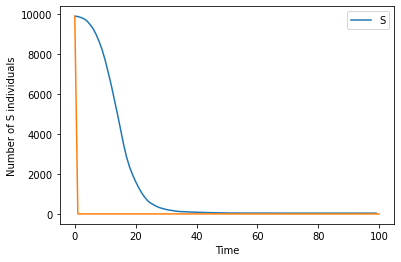

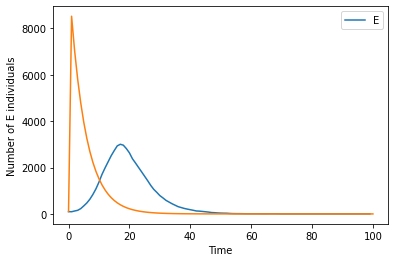

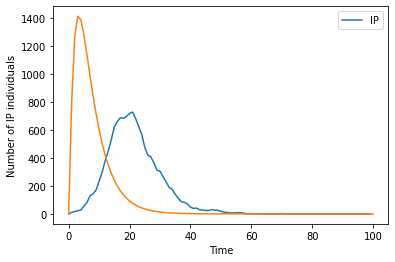

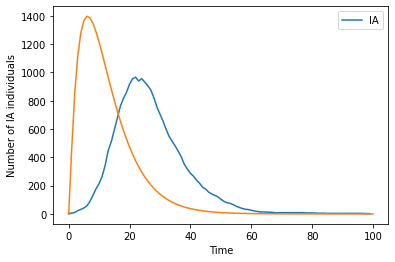

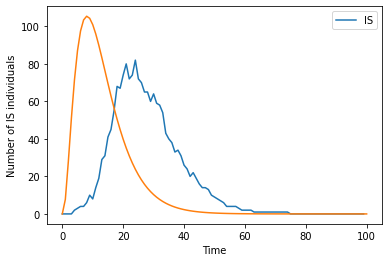

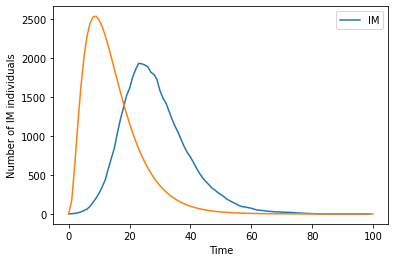

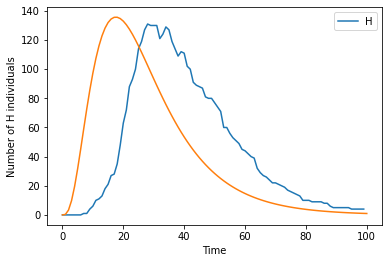

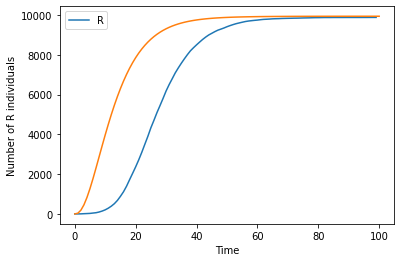

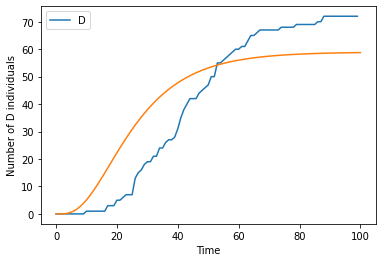

In [6]:
Gil_soln = Gillespie_Run(pars,Cpars,n0,pop,100)
an_soln = np.array(num_soln(pars,Cpars,n0,100))

for i in range(1,len(labels)+1):
    plt.plot(Gil_soln[:,0],Gil_soln[:,i],label=labels[i-1])
    plt.plot(an_soln[0,:],an_soln[i,:])
    plt.xlabel("Time")
    plt.ylabel("Number of "+labels[i-1]+ " individuals")
    plt.legend()
    plt.show()